In [213]:
import re
import pathlib
import json
import os
from typing import Dict, List, Union

# log utils
def parse_logfile(text: str) -> Dict:
    """ログファイルを正規表現でparse

    Args:
        text (str): ログファイル. 

    Returns:
        Dict: 
                [AgentParameters]
                (json) → Dict["params"]
                [AgentManager]
                (json) → Dict["result]
    """
    parser = re.compile(r'-{15}\n\[.*\]\n(?P<params>.*)\n\[.*\]\n(?P<results>.*)')
    matches = parser.findall(text)
    
    data = []
    if matches:
        for match in matches:
            datum = {}
            datum["params"] = json.loads(match[0])
            datum["result"] = json.loads(match[1])
            data.append(datum)
    return data

def get_latest_log_file(log_folder_path: pathlib.Path):
    """最新のログファイルを取得

    Args:
        log_folder_path (Pathlib.path): ログフォルダへのパス
    """
    log_file = pathlib.Path(sorted(list(log_folder_path.glob('*.txt')))[-1])
    return log_file

def get_file_content(file_path: pathlib.Path) -> str:
    """ファイルの中身を取得するだけ
    """
    with open(file_path, 'r') as f:
        file_content = f.read()
    return file_content

# PSO Visualization

In [214]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

def format_data(data, nSamples, nParticles):
    x = np.array([datum["params"][0]["zoo"] for datum in data])
    y = np.array([datum["params"][0]["zoa"] for datum in data])
    z = np.array([datum["result"]["deadCount"][0] for datum in data])

    avg_x = np.array([x[i:i + nSamples].mean() for i in range(0, len(x), nSamples)])
    avg_y = np.array([y[i:i + nSamples].mean() for i in range(0, len(y), nSamples)])
    avg_z = np.array([z[i:i + nSamples].mean() for i in range(0, len(z), nSamples)])
    
    generations = []
    for i in range(0, int(len(avg_x) / nParticles)):
        generations.append((avg_x[i * nParticles : (i + 1) * nParticles],
                          avg_y[i * nParticles : (i + 1) * nParticles],
                          avg_z[i * nParticles : (i + 1) * nParticles]))

    return np.array(generations)

def draw_3d_graph(generations, angle, gens, all=True, progress=-1):
    plt.cla()
    nParticles = len(generations[0][0])

    if progress != -1:
        assert 0.0 <= progress and progress <= 1.0
        if len(generations) >= 2:
            mid = (1.0 - progress) * generations[-2] + progress * generations[-1]
            generations[-1] = mid

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    ax.view_init(azim=angle)

    for particle in range (0, nParticles):
        x = []
        y = []
        z = []
        for generation in generations:
            x.append(generation[0][particle])
            y.append(generation[1][particle])
            z.append(generation[2][particle])
        tail = 3
        ax.plot(x[-tail:], y[-tail:], z[-tail:], alpha=0.1)
        if progress != -1:
            ax.plot(x[-(tail + 1):-(tail - 1)], y[-(tail + 1):-(tail - 1)], z[-(tail + 1):-(tail - 1)], alpha=0.1 * (1 - progress))
        ax.scatter(x[-1], y[-1], z[-1])

    plt.xlabel('x')
    plt.ylabel('y')

    plt.title(f'{len(generations)}/{gens}')

    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
    ax.set_zlim([0, 100])

def draw_2d_graph(generations, gens, all=True, progress=-1):
    plt.cla()
    nParticles = len(generations[0][0])

    if progress != -1:
        assert 0.0 <= progress and progress <= 1.0
        if len(generations) >= 2:
            mid = (1.0 - progress) * generations[-2] + progress * generations[-1]
            generations[-1] = mid

    for particle in range (0, nParticles):
        x = []
        y = []
        for generation in generations:
            x.append(generation[0][particle])
            y.append(generation[1][particle])
        plt.plot(x[-5:], y[-5:], alpha=0.1)
        plt.scatter(x[-1], y[-1])

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    plt.xlabel('x')
    plt.ylabel('y')

    plt.xlim([0, 15])
    plt.ylim([0, 15])

    plt.title(f"{len(generations)}/{gens}")

def ease_in_out_cubic(x):
    if x < 0.5:
        return 4*x*x*x
    else:
        return 1 - pow(-2*x + 2, 3) / 2

### Parameters & Data

In [215]:
import numpy as np
import time
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
import imageio

nSamples = 1
nParticles = 10

steps = 4

log_folder_path = pathlib.Path(os.path.expanduser("~/Desktop")) / "CouzinAlgorithmsLogs"
angle = 0

data = parse_logfile(get_file_content(get_latest_log_file(log_folder_path)))

generations = format_data(data, nSamples, nParticles)

### 2D

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


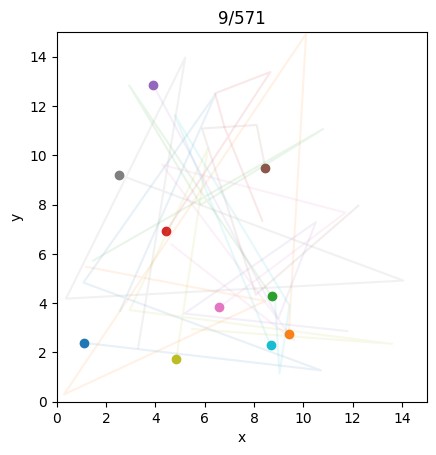

In [207]:
images = []
# for i in tqdm(range(2, len(generations))):
for i in tqdm(range(2, 10)): 
    for step in range (0, steps):
        draw_2d_graph(np.copy(generations[:i]), gens=len(generations), all=True, progress=ease_in_out_cubic(step / steps))
        filename = f'frames/2d/output_{i}_{step}.png'
        plt.savefig(filename)
        images.append(imageio.imread(filename))
        clear_output(wait=True)

imageio.mimsave('images/2d.gif', images)

### 3D

In [216]:
images = []
angle = 0
for i in tqdm(range(2, len(generations))):
    for step in range (0, steps):
        angle += 1
        draw_3d_graph(np.copy(generations[:i]), angle, gens=len(generations), progress=ease_in_out_cubic(step / steps))
        filename = f'frames/3d/output_{i}_{step}.png'
        plt.savefig(filename, dpi=120)
        plt.close()
        images.append(imageio.imread(filename))
        clear_output(wait=True)

imageio.mimsave('images/3d.gif', images)

0it [00:00, ?it/s]